loganjtravis@gmail.com (Logan Travis)

In [88]:
%%capture --no-stdout

# Imports; captures errors to supress warnings about changing
# import syntax
from lxml import html
import matplotlib.pyplot as plot
import nltk
import numpy as np
import pandas as pd
import random
import re
import wikipediaapi

In [2]:
# Set random seed for repeatability
random.seed(42)

In [77]:
# Set matplotlib to inline to preserve images in PDF
%matplotlib inline

# Summary

From course page [Week 3 > Task 3 Information > Task 3 Overview](https://www.coursera.org/learn/data-mining-project/supplement/7Ro4J/task-3-overview):

> The goal of this task is to mine the data set to discover the common/popular dishes of a particular cuisine. Typically when you go to try a new cuisine, you don’t know beforehand the types of dishes that are available for that cuisine. For this task, we would like to identify the dishes that are available for a cuisine by building a dish recognizer.
> 
> **Instructions**
>
> Before you begin, make sure you have downloaded the data set and any additional tools you wish to use, as described on the [Data Set and Toolkit Acquisition](https://www.coursera.org/learn/data-mining-project/supplement/Ij7rp/data-set-and-toolkit-acquisition) page.
> 
> Some questions to consider when building the dish recognizer are the following:
> 
> 1. What types of dishes are present in the reviews for a cuisine?
> 2. Are there any surprising dishes in the list you annotated?
> 3. What types of dishes were you able to find?

# Clean List of Dishes for Mexican Cuisine

I chose to explore dishes for Mexican cuisine. I both enjoy Mexican food and thought the use of Spanish words might yield interesting results.

In [65]:
# Set paths to data source, work in process ("WIP"), and output
PATH_SOURCE = "source/"
PATH_WIP = "wip/"
PATH_OUTPUT = "output/"

# Set file paths
PATH_SOURCE_MEXICAN_LABELS = PATH_SOURCE + "labels/Mexican.label"
PATH_SOURCE_MEXICAN_TO_DEL = PATH_SOURCE + "labels/Mexican_TO_DEL.label"
PATH_SOURCE_MEXICAN_TO_FLIP = PATH_SOURCE + "labels/Mexican_TO_FLIP.label"
PATH_SOURCE_YELP_REVIEWS = PATH_SOURCE + \
        "yelp_academic_dataset_review.pkl.gzip"
PATH_SOURCE_YELP_REST_TO_CUISINES = PATH_SOURCE + \
        "yelp_academic_dataset_restaurant_to_cuisine.pkl.gzip"
PATH_WIP_YELP_REVIEWS_MEXICAN = PATH_WIP + \
        "yelp_academic_dataset_review_mexican_corpus.txt"
PATH_WIP_MEXICAN_FINAL = PATH_WIP + "labels/Mexican_FINAL.label"

# Set paths to AutoPhrase output
AUTOPHRASE_LOG = "AutoPhrase/models/yelp_mexican_dishes/log.txt"
AUTOPHRASE_RESULTS = "AutoPhrase/models/yelp_mexican_dishes/AutoPhrase.txt"
AUTOPHRASE_RESULTS_BLIND = "AutoPhrase/models/yelp_mexican_dishes_blind/AutoPhrase.txt"

## Inspect Provided List

The assignment included an initial list a list of frequent phrases for Mexican cuisine tagged with either a 1 to indicate a *potential* dish name or 0 to indicate a non-dish phrase. I emphasize "potential" because even cursory glance reveals non-dish phrases like "in n out" and "service stars".

In [4]:
# Read initial dish list for Mexican cuisine
dfMexDishes = pd.read_csv(PATH_SOURCE_MEXICAN_LABELS, sep="\t", names=["dish", "include"])

In [5]:
# Make `dish` column the index
dfMexDishes.set_index("dish", inplace=True)

In [6]:
# Set `include` column to boolean data type
dfMexDishes.include = dfMexDishes.include.astype(np.bool_,)

In [8]:
# Print dish list shape and head
print("---INITIAL---")
print("Dish list has shape {} with {:,} dishes to include and {:,} common phrases to exclude as dishes.".format(\
        dfMexDishes.shape, \
        sum(dfMexDishes.include), \
        sum(~dfMexDishes.include)))
dfMexDishes.head(5)

---INITIAL---
Dish list has shape (597, 1) with 200 dishes to include and 397 common phrases to exclude as dishes.


,include
dish,
fried egg,True
in n out,True
triple sec,True
mexican food,True
service stars,True


## Remove False-Positives

I reviewed the list of potential dishes - those frequent phrases tagged with a 1 - to compile a list of fals-positive phrases to remove. That list included both non-dish phrases and dish names not relevant to Mexican cuisine. I removed nearly all of the potential dishes raising a question that I will explore in detail later, "With such poor performance form frequent phrases, how else can I use to create a list of Mexican dishes?"

In [9]:
# Read dishes to drop for Mexican cuisine
wip = pd.read_csv(PATH_SOURCE_MEXICAN_TO_DEL, sep="\t", names=["dish", "include"], index_col=0)

In [10]:
# Removed dishes to drop from dish list
dfMexDishes.drop(wip.index, inplace=True)

In [11]:
# Print dish list shape
print("---AFTER REMOVING FALSE POSITIVES---")
print("Dish list has shape {} with {:,} dishes to include and {:,} common phrases to exclude as dishes.".format(\
        dfMexDishes.shape, \
        sum(dfMexDishes.include), \
        sum(~dfMexDishes.include)))

---AFTER REMOVING FALSE POSITIVES---
Dish list has shape (412, 1) with 15 dishes to include and 397 common phrases to exclude as dishes.


## Flip Indicator for False-Negatives

I identified less than ten false-negatives, dish names tagged with a 0, that I correct below.

In [12]:
# Read dishes flip drop for Mexican cuisine
wip = pd.read_csv(PATH_SOURCE_MEXICAN_TO_FLIP, sep="\t", names=["dish", "include"], index_col=0)

In [13]:
# Removed dishes to drop from dish list
dfMexDishes.loc[wip.index, "include"] = ~dfMexDishes.loc[wip.index, "include"]

In [14]:
# Print dish list shape
print("---AFTER CORRECTIN FALSE NEGATIVES---")
print("Dish list has shape {} with {:,} dishes to include and {:,} common phrases to exclude as dishes.".format(\
        dfMexDishes.shape, \
        sum(dfMexDishes.include), \
        sum(~dfMexDishes.include)))

---AFTER CORRECTIN FALSE NEGATIVES---
Dish list has shape (412, 1) with 21 dishes to include and 391 common phrases to exclude as dishes.


## Add Dishes from Wikipedia

As noted earlier, very few of the frequent phrases qualify as Mexican dishes. I decided to seek other sources finding [Wikipedia page for "List of Mexican dishes"](https://en.wikipedia.org/wiki/List_of_Mexican_dishes). The [AutoPhrase](https://github.com/shangjingbo1226/AutoPhrase) package - an improved version of [SegPhrase](https://github.com/shangjingbo1226/SegPhrase) - I use later *should* benefit from an expert list of labels. The cleaned list of frequent phrases includes fewer than 25 dish names. I therefore decided to add the list of dishes on Wikipedia.

In [15]:
# Get Wikipedia page "List of Mexican dishes" and parse as HTML
wp = wikipediaapi.Wikipedia('en', extract_format=wikipediaapi.ExtractFormat.HTML)
wpMexDishesPage = wp.page("List_of_Mexican_dishes")

In [16]:
# Define helper function to pretty-print secitons
def printSections(sections, level=0):
    """Pretty-print sections from `wikipediaapi` page."""
    for i, s in enumerate(sections):
        print("{}{:d}. {}".format(" " * 4 * level, i, s.title))
        printSections(s.sections, level + 1)

In [17]:
# Examine sections
printSections(wpMexDishesPage.sections)

0. Antojitos
1. Cheese  dishes
2. Egg dishes
3. Meat dishes
    0. Beef dishes
    1. Goat dishes
    2. Pork dishes
    3. Poultry dishes
    4. Other meat and protein dishes
4. Moles, sauces, dips and spreads
5. Rice dishes
6. Seafood dishes
7. Soups and stews
8. Vegetable dishes
9. Desserts and sweets
10. Beverages
    0. Non-alcoholic
    1. Alcoholic
11. See also
12. References
13. External links


In [18]:
# Get text from an example section
wpMexDishesPage.sections[0].text

'<p>Street food in Mexico, called <i>antojitos</i> is prepared by street vendors and at small traditional markets in Mexico. Most of them include corn as an ingredient.\n</p>\n<ul><li>Aguachile</li>\n<li>Bolillos (salty bread)</li>\n<li>Burrito</li>\n<li>Camote (Mexican sweet potato)</li>\n<li>Cemitas sandwiches</li>\n<li>Chalupa</li>\n<li>Chapulines and escamoles</li>\n<li>Charales, small fish, basically a type of smelt</li>\n<li>Chicharrón</li></ul>\n<ul><li>Chilaquiles</li>\n<li>Chimichangas (Tex-Mex mostly)</li>\n<li>Choriqueso</li>\n<li>Chorizo</li></ul>\n<ul><li>Cochinita pibil</li>\n<li>Cocido</li>\n<li>Cóctel de camarón and other seafood cocktails</li>\n<li>Corunda</li>\n<li>Curtido</li>\n<li>Elote</li>\n<li>Enchilada (red or green)</li>\n<li>Enfrijoladas</li>\n<li>Ensalada de fruta (fruit salad)</li>\n<li>Entomatadas</li>\n<li>Fajitas</li>\n<li>Filete de pescado</li></ul>\n<ul><li>Flautas</li>\n<li>Frijoles charros</li>\n<li>Fritada</li>\n<li>Gorditas</li>\n<li>Gringas</li>\n<

Each section includes one or more unorder list of dish names. Those dish names includes some unwanted text, usually explanatory, that I remove with the helper function below.

In [19]:
# Define helper function to get list of dishes from section text
def getDishesFromText(sectionText, removeTextAfter="[,-]", wordLimit=3):
    """Return a list of dish names from section text."""
    tree = None
    
    # Create an `lxml` element tree from HTML.
    tree = html.fromstring(sectionText)
    
    # Get dishes from <li> element text
    dishes = tree.xpath("//li/text()")
    
    # Remove parentheticals
    dishes = [re.sub(r"\(.*?\)", "", t) for t in dishes]
    
    # Remove text after passed characters
    dishes = [re.sub("(?<={}).*$".format(removeTextAfter), "", t) for t in dishes]
    
    # Trim to word limit
    dishes = [" ".join(re.split(r"\W+", t)[:wordLimit]).strip() for t in dishes]
    
    # Return list of dishes
    return set(dishes)

In [20]:
# Define helper function to recursively get dishes from all
# sections
def getDishesFromSection(section):
    """Recusively print list of sections from `wikipediaapi` page."""
#     print(section.title)
    if(len(section.sections) == 0):
        return getDishesFromText(section.text)
    else:
        dishes = set()
        for s in section.sections:
            dishes.update(getDishesFromSection(s))
        return dishes

In [21]:
# Get Mexican dishes from Wikipedia page "List of Mexican dishes"
wpMexDishes = set()
for section in wpMexDishesPage.sections[:11]:
    wpMexDishes.update(getDishesFromSection(section))

In [22]:
# Remove empty items and known bad elements then format for
# inclusion in common phrases
wpMexDishes = [(d.lower(), 1) for d in wpMexDishes \
               if d not in ["is of", "or", "", "as a", "where these"]]

In [23]:
# Convert to dataframe
dfMexDishesFromWP = pd.DataFrame(wpMexDishes, columns=["dish", "include"])

In [24]:
# Make `dish` column the index
dfMexDishesFromWP.set_index("dish", inplace=True)

In [25]:
# Set `include` column to boolean data type
dfMexDishesFromWP.include = dfMexDishesFromWP.include.astype(np.bool_,)

In [26]:
# Merge original dish list and Wikipedia dish list then
# fill missing values as False
dfMexDishes = dfMexDishes.merge(dfMexDishesFromWP, how="outer", \
                                left_index=True, right_index=True, \
                                suffixes=["_initial", "_from_wp"])
dfMexDishes.fillna(False, inplace=True)

In [27]:
# Determine final inclusion from initial list or from 
# Wikipedia
dfMexDishes["include_combined"] = dfMexDishes.include_initial | dfMexDishes.include_from_wp

In [28]:
# List dishes to include
print("---FINAL---")
print("Found {:,} dishes to incldue and {:,} common phrases to exclude as dishes.".format(\
        sum(dfMexDishes.include_combined), \
        sum(~dfMexDishes.include_combined)))

---FINAL---
Found 242 dishes to incldue and 391 common phrases to exclude as dishes.


In [29]:
# Save dish list to working file for read into AutoPhrase
includeDishes = dfMexDishes[dfMexDishes.include_combined].index.to_series()
includeDishes.to_csv(PATH_WIP_MEXICAN_FINAL, header=False, index=False)

# Evaluate Dish List Against Frequent Phrases

The "distant expert" - a term used by [AutoPhrase](https://github.com/shangjingbo1226/AutoPhrase)'s authors \[1\]\[2\] - list of Mexican dishes clearly out performed the initial frequent phrase list. However, [AutoPhrase](https://github.com/shangjingbo1226/AutoPhrase) like [SegPhrase](https://github.com/shangjingbo1226/SegPhrase) before it can improve its frequent phrase mining by introducing a list of known good labels. I do not expect it to beat the distant experts but want to evaluate how much it improves.

## Save Yelp Reviews for Mexican Cuisine to Text Corpus

[AutoPhrase](https://github.com/shangjingbo1226/AutoPhrase) is written in Java and provides multiple ways to read a corpus. I chose to saved the Yelp review text to a single file with each line representing one review (aka "document").

*Note:* I cannot run [AutoPhrase](https://github.com/shangjingbo1226/AutoPhrase) within this notebook as it is a Java application. I will imoprt the output and run log for further review.

In [30]:
# Read saved data
dfYelpReviews = pd.read_pickle(PATH_SOURCE_YELP_REVIEWS)
dfYelpRestToCuis = pd.read_pickle(PATH_SOURCE_YELP_REST_TO_CUISINES)

In [31]:
# Filter restaurants to those tagged with "Mexican" category
dfYelpRestMexican = dfYelpRestToCuis[dfYelpRestToCuis.categories.apply(\
        lambda cats: "Mexican" in cats)]

In [32]:
# Join (inner) reviews to restaurants
dfYelpReviews = dfYelpReviews.join(dfYelpRestMexican, \
                                   on="business_id", \
                                   how="inner", \
                                   rsuffix="_business")

In [38]:
# Print review shape
print("Found {:,} reviews in Yelp data set for Mexican cuisine.".format(\
        dfYelpReviews.shape[0]))

Found 70,406 reviews in Yelp data set for Mexican cuisine.


In [33]:
# Save review text to working file for read by AutoPhrase
dfYelpReviews.text.to_csv(PATH_WIP_YELP_REVIEWS_MEXICAN, index=False, header=False)

## Review AutoPhrase Run Log

I ran [AutoPhrase](https://github.com/shangjingbo1226/AutoPhrase) with custom `MODEL`, `RAW_TRAIN`, and `RAW_LABEL_FILE` parameters to train it agains the Yelp reviews for Mexican restaurants and the expert labels. Full command:

```bash
MODEL='./models/yelp_mexican_dishes' RAW_TRAIN='./wip/yelp_academic_dataset_review_mexican_corpus.txt' RAW_LABEL_FILE='./wip/labels/Mexican_FINAL.label' ./auto_phrase.sh  2>&1 | tee ./models/yelp_mexican_dishes/log.txt
```

In [39]:
# Print AutoPhrase log file
with open(AUTOPHRASE_LOG, "r") as f:
    print(f.read())

===Compilation===(B
===Tokenization===(B
Current step: Tokenizing input file...
real	0m6.207s
user	0m19.266s
sys	0m2.734s
Detected Language: EN
Current step: Tokenizing stopword file...
Current step: Tokenizing wikipedia phrases...
Current step: Tokenizing expert labels...
===Part-Of-Speech Tagging===(B
Current step: Splitting files...
Current step: Tagging...
Current step: Merging...
===AutoPhrasing===(B
=== Current Settings ===
Iterations = 2
Minimum Support Threshold = 10
Maximum Length Threshold = 6
POS-Tagging Mode Enabled
Number of threads = 10
Labeling Method = DPDN
	Auto labels from knowledge bases
	Max Positive Samples = -1
Loading data...
# of total tokens = 9309127
max word token id = 55658
# of documents = 258937
# of distinct POS tags = 57
Mining frequent phrases...
selected MAGIC = 55661
# of frequent phrases = 130895
Extracting features...
Constructing label pools...
	The size of the positive pool = 6660
	The size of the negative pool = 123532
# truth patterns = 9645

## Compare AutoPhrase to Expert Labels

*

In [99]:
# Read AutoPhrase frequent phrases into dataframe
dfPhrases = pd.read_csv(AUTOPHRASE_RESULTS, sep="\t", \
                        names=["score", "dish"], index_col="dish")

In [47]:
# Print dish list shape and head
print("---AUTOPHRASE WITH EXPERT LABELS---")
print("Found {:,} frequent phrases with scores ranging from {:.4f} to {:.4f}.".format(\
        apPhrases.shape[0], \
        max(apPhrases.score), \
        min(apPhrases.score)))
dfPhrases.head(5)

---AUTOPHRASE WITH EXPERT LABELS---
Found 62,259 frequent phrases with scores ranging from 0.9866 to 0.0025.


,score
dish,
fort apache,0.986563
crescent ballroom,0.986338
sin city,0.985787
tivoli village,0.985641
sky harbor,0.985629


**Not an impressive result** for the most frequent phrases. Perhaps the expert labels still have high scores.

In [49]:
# Create expert dish, frequent phrase, interestion, and 
# difference sets
dishes = set(dfMexDishes[dfMexDishes.include_combined].index)
phrases = set(dfPhrases.index)
dishesInPhrases = dishes.intersection(phrases)
dishesNotInPhrases = dishes.difference(phrases)

In [57]:
# List top-10 dishes in frequent phrases
dfPhrases.loc[dishesInPhrases].sort_values("score", ascending=False).head(10)

,score
dish,
pollo asado,0.975782
noodle soup,0.965598
mashed potatoes,0.963162
pot roast,0.962596
cochinita pibil,0.961179
huevos rancheros,0.960683
aguas frescas,0.959153
chiles en nogada,0.956810
mole poblano,0.951019


*

In [58]:
# List bottom-10 dishes in frequent phrases
dfPhrases.loc[dishesInPhrases].sort_values("score", ascending=False).tail(10)

,score
dish,
tostadas,0.594016
chalupa,0.591957
mezcal,0.590889
bistec,0.588662
tortillas,0.575958
fideos,0.574822
chips and salsa,0.549521
carnitas bowl,0.425216
mole chicken,0.381411


*

In [64]:
# List missed dishes
print("AutoPhrase missed {:,} dishes from expert labels. Examples:".format(len(dishesNotInPhrases)))
print(list(dishesNotInPhrases)[:10])

AutoPhrase missed 148 dishes from expert labels. Examples:
['arroz rojo', 'calabacitas con puerco', 'milanesas chicken', 'alegrías', 'corunda', 'aporreadillo', 'mazapán de cacahuate', 'tubâ', 'arroz con leche', 'buñuelos']


*

## Compare Blind AutoPhrase

*

In [100]:
# Read AutoPhrase frequent phrases wihtou expert labels
# into dataframe
dfPhrasesBlind = pd.read_csv(AUTOPHRASE_RESULTS_BLIND, sep="\t", \
                             names=["score", "dish"], index_col="dish")

In [68]:
# Print dish list shape and head
print("---AUTOPHRASE WITHOUT EXPERT LABELS---")
print("Found {:,} frequent phrases with scores ranging from {:.4f} to {:.4f}.".format(\
        dfPhrasesBlind.shape[0], \
        max(dfPhrasesBlind.score), \
        min(dfPhrasesBlind.score)))

---AUTOPHRASE WITHOUT EXPERT LABELS---
Found 61,567 frequent phrases with scores ranging from 0.9873 to 0.0028.


In [101]:
# Merge with expert label results
dfPhrases = dfPhrases.merge(dfPhrasesBlind, left_index=True, right_index=True, \
                suffixes=["_expert", "_blind"])

In [102]:
# Re-create expert dish, frequent phrase, interestion, and 
# difference sets
dishes = set(dfMexDishes[dfMexDishes.include_combined].index)
phrases = set(dfPhrases.index)
dishesInPhrases = dishes.intersection(phrases)
dishesNotInPhrases = dishes.difference(phrases)

In [103]:
# List top-10 dishes in frequent phrases
dfPhrases.loc[dishesInPhrases].sort_values("score_expert", \
                                           ascending=False).head(10)

,score_expert,score_blind
dish,,
pollo asado,0.975782,0.966919
noodle soup,0.965598,0.966308
mashed potatoes,0.963162,0.967911
pot roast,0.962596,0.967622
cochinita pibil,0.961179,0.974011
huevos rancheros,0.960683,0.964055
aguas frescas,0.959153,0.961809
chiles en nogada,0.956810,0.957931
mole poblano,0.951019,0.965613


*

In [104]:
# List bottom-10 dishes in frequent phrases
dfPhrases.loc[dishesInPhrases].sort_values("score_expert", \
                                           ascending=False).tail(10)

,score_expert,score_blind
dish,,
tostadas,0.594016,0.600997
chalupa,0.591957,0.571953
mezcal,0.590889,0.585701
bistec,0.588662,0.598149
tortillas,0.575958,0.615121
fideos,0.574822,0.599146
chips and salsa,0.549521,0.530412
carnitas bowl,0.425216,0.424669
mole chicken,0.381411,0.369635


*

In [105]:
# Calculate score improvement. Assume 0 score for NaN.
dfPhrases.fillna(0, inplace=True)
dfPhrases["improvement"] = dfPhrases.score_expert - dfPhrases.score_blind

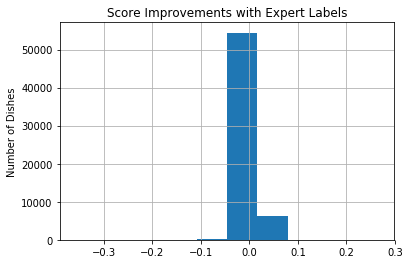

In [106]:
# Plot score improvement
_, _, _ = plot.hist(dfPhrases.improvement)
plot.ylabel("Number of Dishes")
plot.title("Score Improvements with Expert Labels")
plot.grid(True)
plot.show()

*

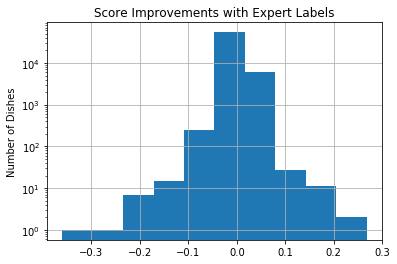

In [108]:
# Plot score improvement with 
_, _, _ = plot.hist(dfPhrases.improvement)
plot.yscale("log", nonposy="clip")
plot.ylabel("Number of Dishes")
plot.title("Score Improvements with Expert Labels")
plot.grid(True)
plot.show()

# Conclusions

*

# AutoPhrase Publications

[AutoPhrase](https://github.com/shangjingbo1226/AutoPhrase) arose form the contributions of two publications:

1. Jingbo Shang, Jialu Liu, Meng Jiang, Xiang Ren, Clare R Voss, Jiawei Han, "[Automated Phrase Mining from Massive Text Corpora](https://arxiv.org/abs/1702.04457)", accepted by IEEE Transactions on Knowledge and Data Engineering, Feb. 2018.
2. Jialu Liu*, Jingbo Shang*, Chi Wang, Xiang Ren and Jiawei Han, "[Mining Quality Phrases from Massive Text Corpora](http://hanj.cs.illinois.edu/pdf/sigmod15_jliu.pdf)”, Proc. of 2015 ACM SIGMOD Int. Conf. on Management of Data (SIGMOD'15), Melbourne, Australia, May 2015. (* equally contributed, [slides](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/sigmod15SegPhrase.pdf))